In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

--------------------------------------------------------------
# Load data
--------------------------------------------------------------

In [2]:
df = pd.read_pickle('../../data/interim/02_outliers_removed_chauvenet.pkl')
predictor_columns = list(df.columns[:6])

In [3]:
# plot settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2

--------------------------------------------------------------
# Dealing with missing values (imputation)
--------------------------------------------------------------

In [4]:
for col in predictor_columns:
    df[col] = df[col]. interpolate()

--------------------------------------------------------------
# Calculating set duration
--------------------------------------------------------------

In [5]:
for s in df['set'].unique():
    start = df[df['set'] == s].index[0]
    stop = df[df['set'] == s].index[-1]
    duration = stop - start
    df.loc[(df['set'] == s), 'duration'] = duration.seconds

In [6]:
duration_df = df.groupby(['category'])['duration'].mean()
duration_df

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [7]:
print(duration_df.iloc[0] / 5)
print(duration_df.iloc[1] / 10)

2.9487001733102254
2.4942528735632186


--------------------------------------------------------------
# Butterworth lowpass filter
--------------------------------------------------------------

In [8]:
df_lowpass = df.copy()
LowPass = LowPassFilter()

In [9]:
fs = 1000 / 200
cutoff = 1.25

df_lowpass = LowPass.low_pass_filter(df_lowpass, 'acc_y', fs, cutoff, order = 5)
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,bench,heavy,B,30,16.0,0.977016
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,bench,heavy,B,30,16.0,0.973058
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,bench,heavy,B,30,16.0,0.965123
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,bench,heavy,B,30,16.0,0.962422
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,bench,heavy,B,30,16.0,0.963387
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,row,medium,E,90,19.0,-0.980824
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,row,medium,E,90,19.0,-1.039622
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,row,medium,E,90,19.0,-1.048628


ohp


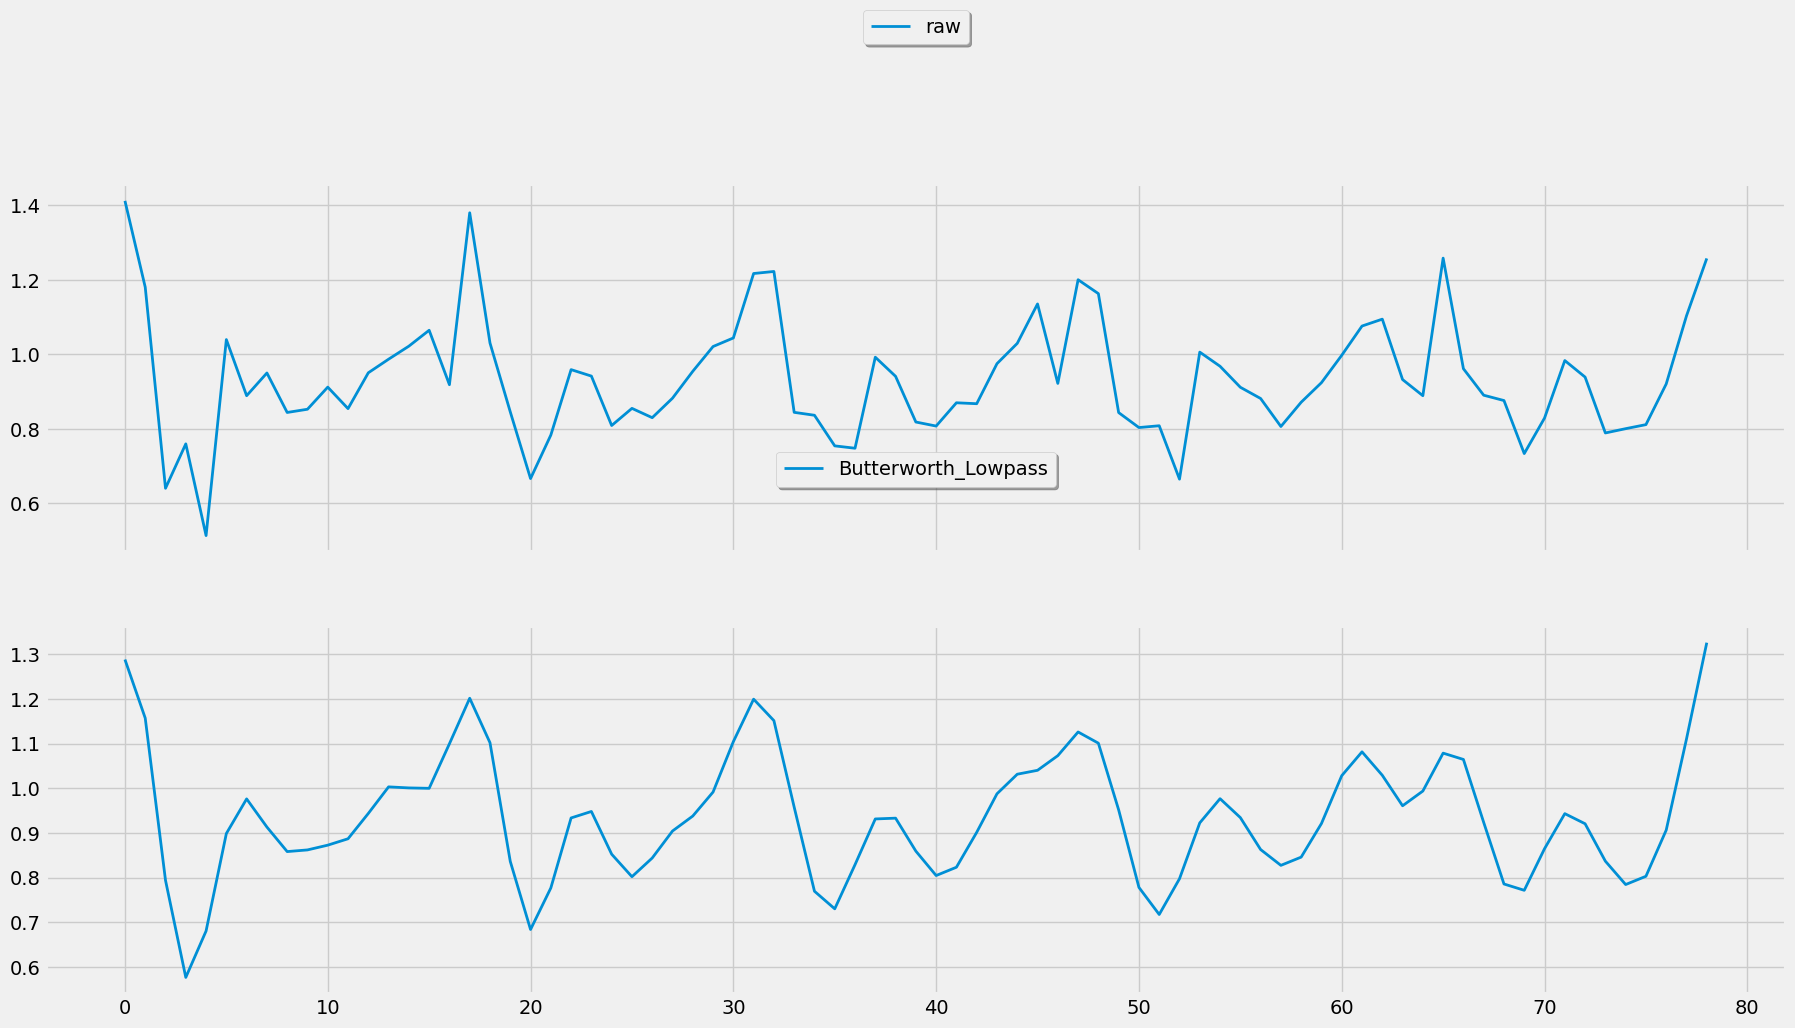

In [10]:
subset = df_lowpass[df_lowpass['set'] == 45]
print(subset['label'][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize = (20,10))
ax[0].plot(subset['acc_y'].reset_index(drop = True), label = 'raw')
ax[1].plot(subset['acc_y_lowpass'].reset_index(drop = True), label = 'Butterworth_Lowpass')
ax[0].legend(loc = 'upper center', bbox_to_anchor = (0.5,1.5), fancybox = True, shadow = True)
ax[1].legend(loc = 'upper center', bbox_to_anchor = (0.5,1.5), fancybox = True, shadow = True)

In [11]:
df_lowpass = df.copy()

for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order = 5)
    df_lowpass[col] = df_lowpass[col + '_lowpass']
    del df_lowpass[col + '_lowpass']

df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013493,0.977016,-0.071001,-1.895512,2.437133,0.940748,bench,heavy,B,30,16.0
2019-01-11 15:08:05.400,0.007992,0.973058,-0.066513,0.899845,0.472271,-0.599037,bench,heavy,B,30,16.0
2019-01-11 15:08:05.600,-0.008917,0.965123,-0.072614,4.268261,-2.066298,-1.100413,bench,heavy,B,30,16.0
2019-01-11 15:08:05.800,-0.023902,0.962422,-0.084710,3.416969,-3.520616,0.139319,bench,heavy,B,30,16.0
2019-01-11 15:08:06.000,-0.021281,0.963387,-0.095423,0.883263,-1.244395,-1.983523,bench,heavy,B,30,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.044249,-0.980824,-0.062005,2.537614,-4.220733,0.207296,row,medium,E,90,19.0
2019-01-20 17:33:27.200,-0.041867,-1.039622,-0.061381,-2.924296,-2.470034,1.421960,row,medium,E,90,19.0
2019-01-20 17:33:27.400,-0.047515,-1.048628,-0.066242,-0.289311,-1.933288,1.151634,row,medium,E,90,19.0


--------------------------------------------------------------
# Principal component analysis PCA
--------------------------------------------------------------

In [12]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

In [13]:
pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

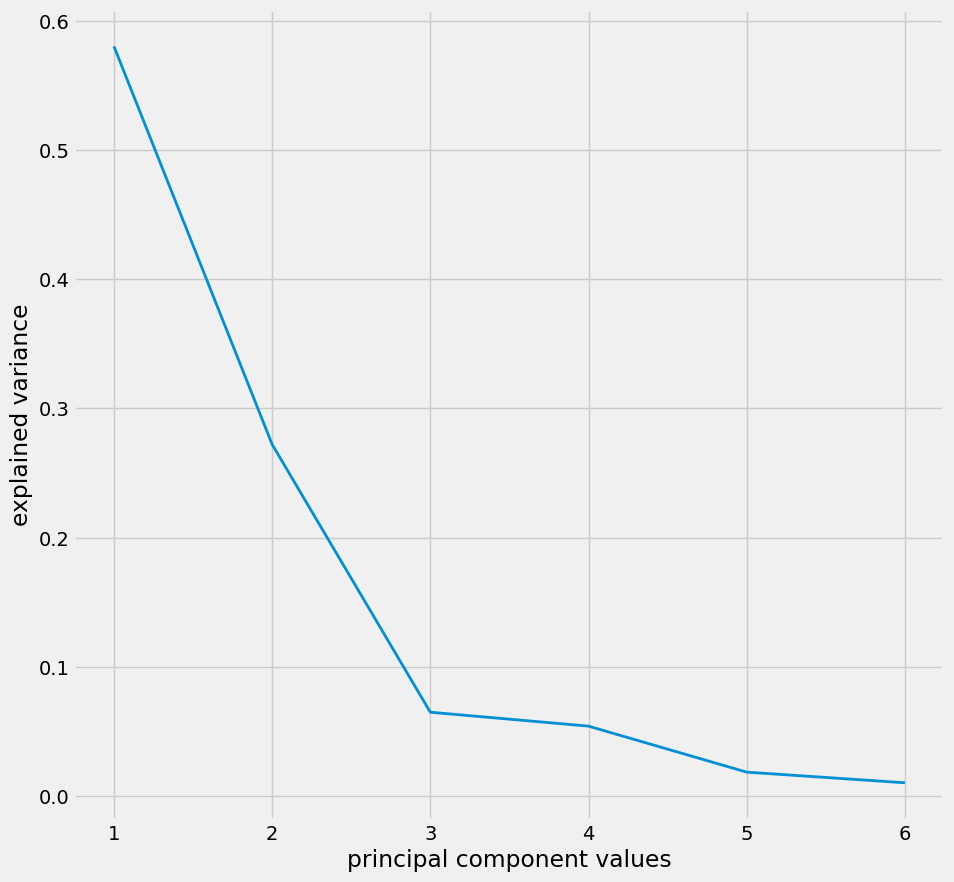

In [14]:
plt.figure(figsize=(10,10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel('principal component values')
plt.ylabel('explained variance')
plt.show()

In [15]:
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

<AxesSubplot: xlabel='epoch (ms)'>

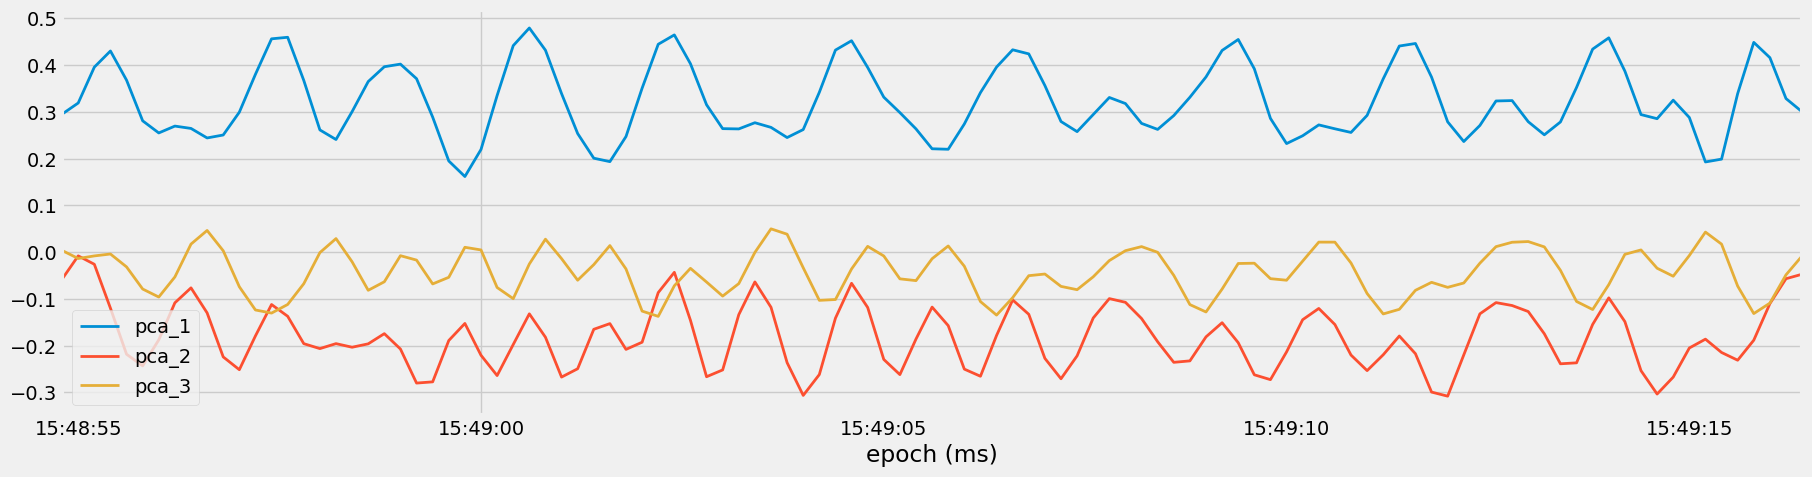

In [16]:
subset = df_pca[df_pca['set'] == 35]
subset[['pca_1','pca_2','pca_3']].plot()

--------------------------------------------------------------
# Sum of squares attributes
--------------------------------------------------------------

In [17]:
df_squared = df_pca.copy()
acc_r = df_squared['acc_x'] ** 2 + df_squared['acc_y'] ** 2 + df_squared['acc_z'] ** 2
gyr_r = df_squared['gyr_x'] ** 2 + df_squared['gyr_y'] ** 2 + df_squared['gyr_z'] ** 2

df_squared['acc_r'] = np.sqrt(acc_r)
df_squared['gyr_r'] = np.sqrt(gyr_r)

array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

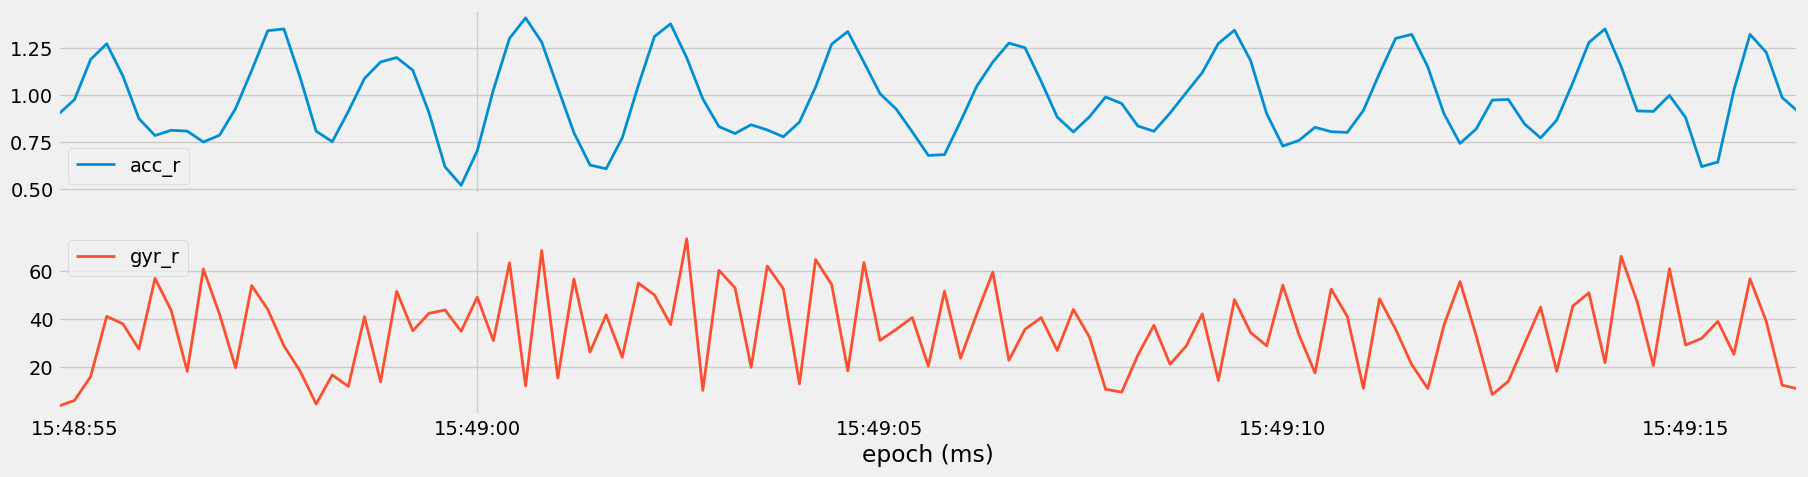

In [18]:
subset = df_squared[df_pca['set'] == 35]
subset[['acc_r','gyr_r']].plot(subplots = True)

--------------------------------------------------------------
# Temporal abstraction
--------------------------------------------------------------

In [19]:
df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns += ['acc_r', 'gyr_r']

ws = int(1000/200)

In [20]:
# for col in predictor_columns:
#     df_temporal = NumAbs.abstract_numerical(df_temporal,[col],ws, 'mean')
#     df_temporal = NumAbs.abstract_numerical(df_temporal,[col],ws, 'std')


In [21]:
df_temporal_list = []
for set in df_temporal['set'].unique():
    subset = df_temporal[df_temporal['set'] == set].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset,[col],ws, 'mean')
        subset = NumAbs.abstract_numerical(subset,[col],ws, 'std')
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

In [22]:
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013493,0.977016,-0.071001,-1.895512,2.437133,0.940748,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.007992,0.973058,-0.066513,0.899845,0.472271,-0.599037,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.008917,0.965123,-0.072614,4.268261,-2.066298,-1.100413,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.023902,0.962422,-0.084710,3.416969,-3.520616,0.139319,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.021281,0.963387,-0.095423,0.883263,-1.244395,-1.983523,bench,heavy,B,30,...,1.514565,2.172880,-0.784381,2.063940,-0.520581,1.005337,0.971543,0.005110,3.337230,1.426539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.044249,-0.980824,-0.062005,2.537614,-4.220733,0.207296,row,medium,E,90,...,-11.914186,18.118583,0.660966,5.420096,7.152635,6.244940,1.082028,0.121167,19.139888,14.962264
2019-01-20 17:33:27.200,-0.041867,-1.039622,-0.061381,-2.924296,-2.470034,1.421960,row,medium,E,90,...,-4.885330,12.579005,-1.516219,3.817091,4.419174,5.049513,1.101328,0.104460,11.595406,10.466144
2019-01-20 17:33:27.400,-0.047515,-1.048628,-0.066242,-0.289311,-1.933288,1.151634,row,medium,E,90,...,0.780303,4.208763,-3.039262,1.386594,1.934812,2.168122,1.063056,0.076910,5.613387,2.533071


<AxesSubplot: xlabel='epoch (ms)'>

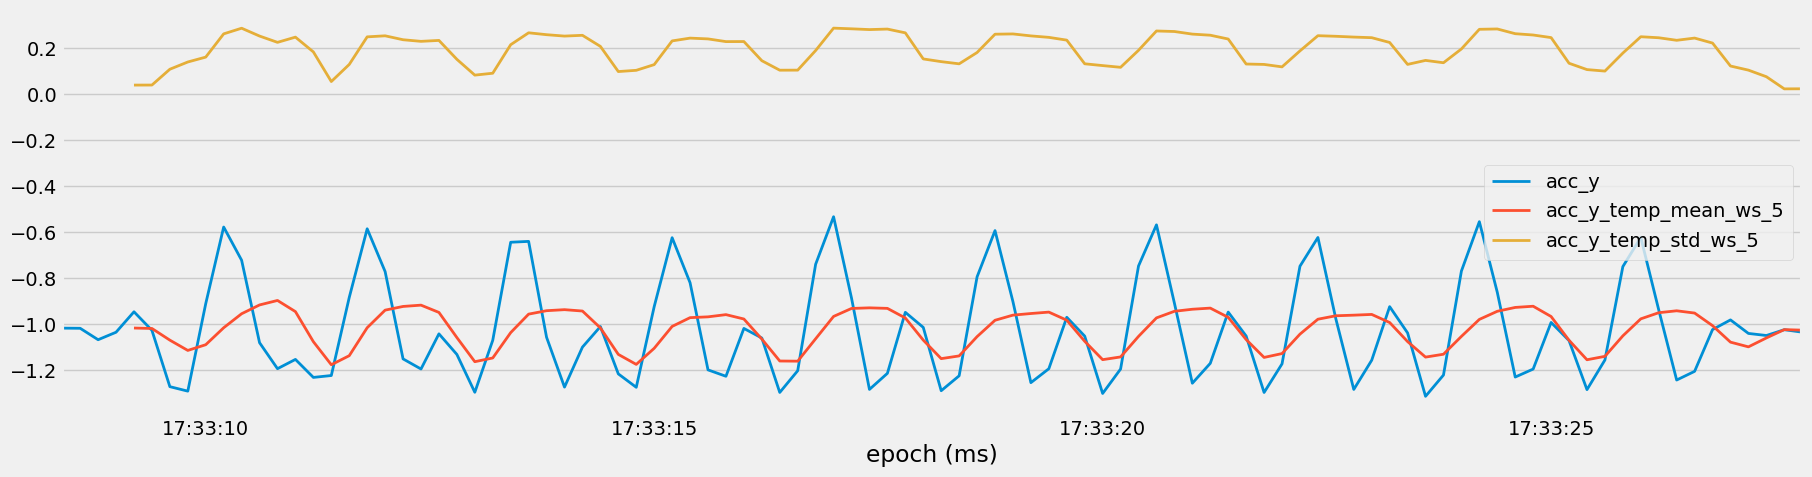

In [23]:
subset[['acc_y','acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5']].plot()

<AxesSubplot: xlabel='epoch (ms)'>

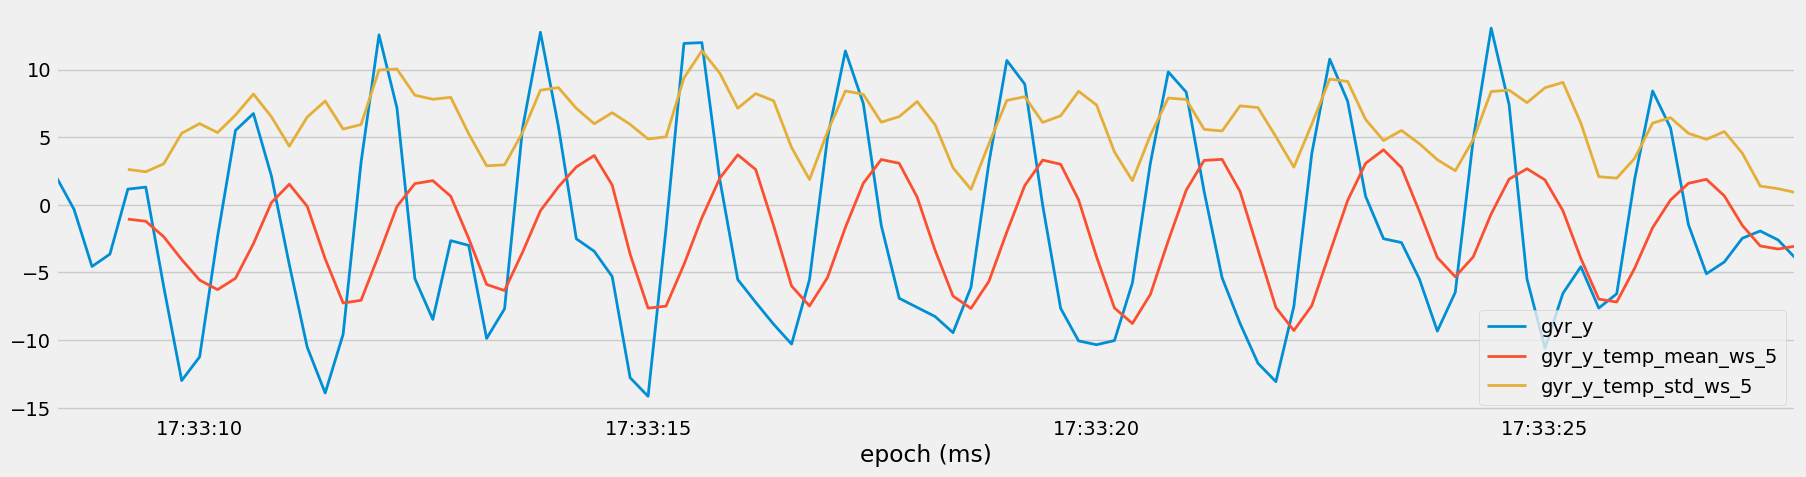

In [24]:
subset[['gyr_y','gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5']].plot()

--------------------------------------------------------------
# Frequency features
--------------------------------------------------------------

In [25]:
df_freq = df_temporal.copy().reset_index()

FreqAbs = FourierTransformation()
ws = int(2800/200)
fs = int(1000/200)

In [26]:
df_freq = FreqAbs.abstract_frequency(df_freq, ['acc_y'], ws, fs)
df_freq.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'label', 'category', 'participant', 'set', 'duration', 'pca_1', 'pca_2',
       'pca_3', 'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5',
       'acc_x_temp_std_ws_5', 'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5',
       'acc_z_temp_mean_ws_5', 'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5',
       'gyr_x_temp_std_ws_5', 'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5',
       'gyr_z_temp_mean_ws_5', 'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5',
       'acc_r_temp_std_ws_5', 'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5',
       'acc_y_max_freq', 'acc_y_freq_weighted', 'acc_y_pse',
       'acc_y_freq_0.0_Hz_ws_14', 'acc_y_freq_0.357_Hz_ws_14',
       'acc_y_freq_0.714_Hz_ws_14', 'acc_y_freq_1.071_Hz_ws_14',
       'acc_y_freq_1.429_Hz_ws_14', 'acc_y_freq_1.786_Hz_ws_14',
       'acc_y_freq_2.143_Hz_ws_14', 'acc_y_freq_2.5_Hz_ws_14'],
      dtype='object')

<AxesSubplot: >

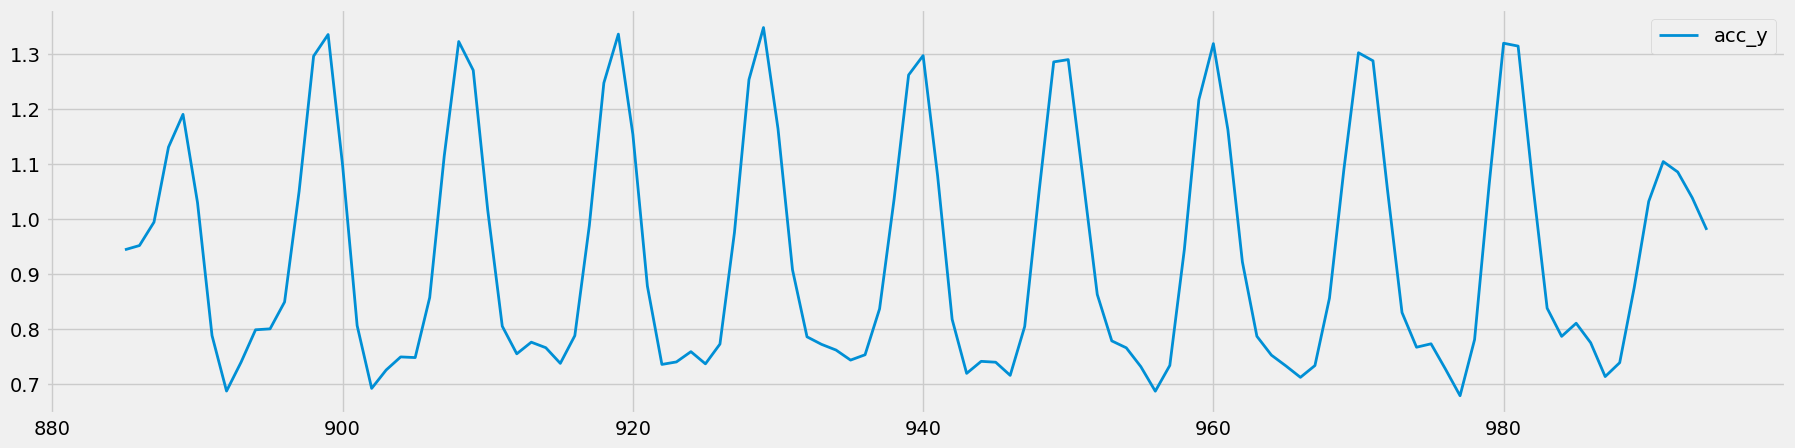

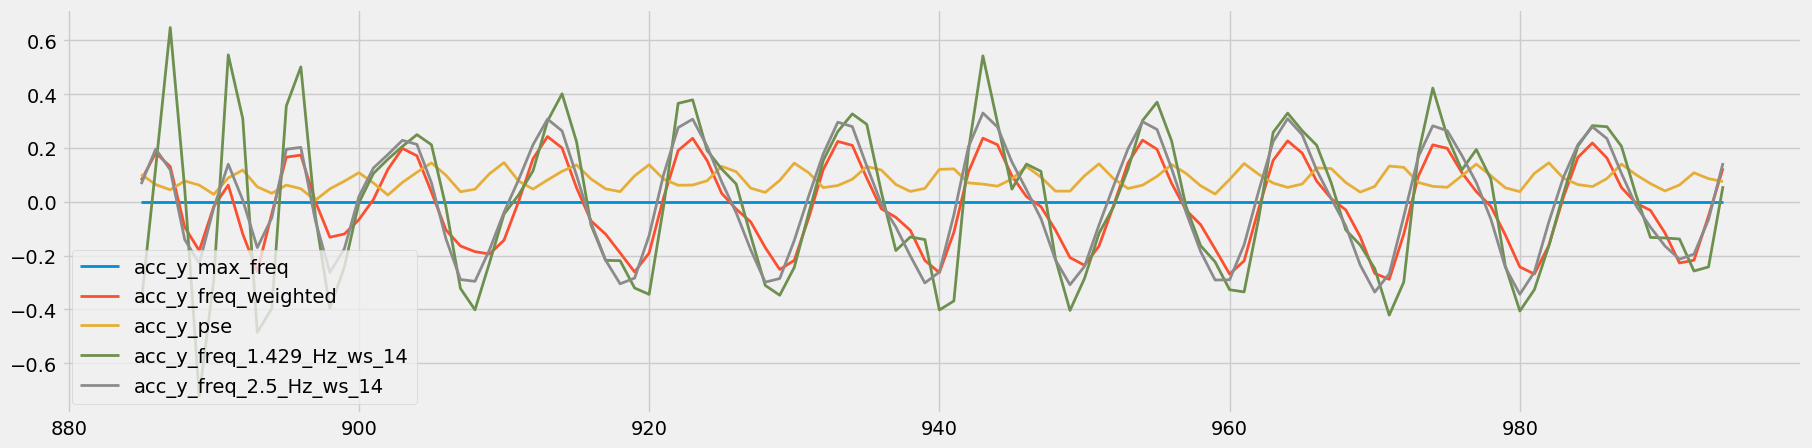

In [27]:
subset = df_freq[df_freq['set'] == 15]
subset[['acc_y']].plot()
subset[[
    'acc_y_max_freq',
    'acc_y_freq_weighted',
    'acc_y_pse',
    'acc_y_freq_1.429_Hz_ws_14',
    'acc_y_freq_2.5_Hz_ws_14'
    ]].plot()

In [28]:
df_freq_list = []
for set in df_freq['set'].unique():
    print(f'Applying fourier transformation to set {set}')
    subset = df_freq[df_freq['set'] == set].reset_index(drop = True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

Applying fourier transformation to set 30
Applying fourier transformation to set 1
Applying fourier transformation to set 31
Applying fourier transformation to set 3
Applying fourier transformation to set 9
Applying fourier transformation to set 32
Applying fourier transformation to set 10
Applying fourier transformation to set 33
Applying fourier transformation to set 11
Applying fourier transformation to set 34
Applying fourier transformation to set 35
Applying fourier transformation to set 15
Applying fourier transformation to set 36
Applying fourier transformation to set 16
Applying fourier transformation to set 37
Applying fourier transformation to set 17
Applying fourier transformation to set 27
Applying fourier transformation to set 38
Applying fourier transformation to set 28
Applying fourier transformation to set 29
Applying fourier transformation to set 6
Applying fourier transformation to set 65
Applying fourier transformation to set 67
Applying fourier transformation to set

In [29]:
df_freq = pd.concat(df_freq_list).set_index('epoch (ms)', drop=True)
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013493,0.977016,-0.071001,-1.895512,2.437133,0.940748,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.007992,0.973058,-0.066513,0.899845,0.472271,-0.599037,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.008917,0.965123,-0.072614,4.268261,-2.066298,-1.100413,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.023902,0.962422,-0.084710,3.416969,-3.520616,0.139319,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.021281,0.963387,-0.095423,0.883263,-1.244395,-1.983523,bench,heavy,B,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.044249,-0.980824,-0.062005,2.537614,-4.220733,0.207296,row,medium,E,90,...,-0.266333,0.228216,317.817105,-33.961383,29.360955,9.810834,-0.539604,-50.514397,-1.124359,0.692747
2019-01-20 17:33:27.200,-0.041867,-1.039622,-0.061381,-2.924296,-2.470034,1.421960,row,medium,E,90,...,0.526753,0.640341,306.882774,-43.539036,62.585079,78.636271,-20.784263,61.342392,14.689431,8.873580
2019-01-20 17:33:27.400,-0.047515,-1.048628,-0.066242,-0.289311,-1.933288,1.151634,row,medium,E,90,...,0.630825,0.565553,267.118953,-70.980120,38.721372,37.435689,19.975481,19.988248,20.460299,31.777128


--------------------------------------------------------------
# Dealing with overlapping windows
--------------------------------------------------------------

In [30]:
df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]

--------------------------------------------------------------
# Clustering
--------------------------------------------------------------

In [32]:
df_cluster = df_freq.copy()

cluster_columns = ['acc_x','acc_y', 'acc_z']
k_values = range(2,10)
inertias = []

In [33]:
for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters = k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    
    inertias.append(kmeans.inertia_)

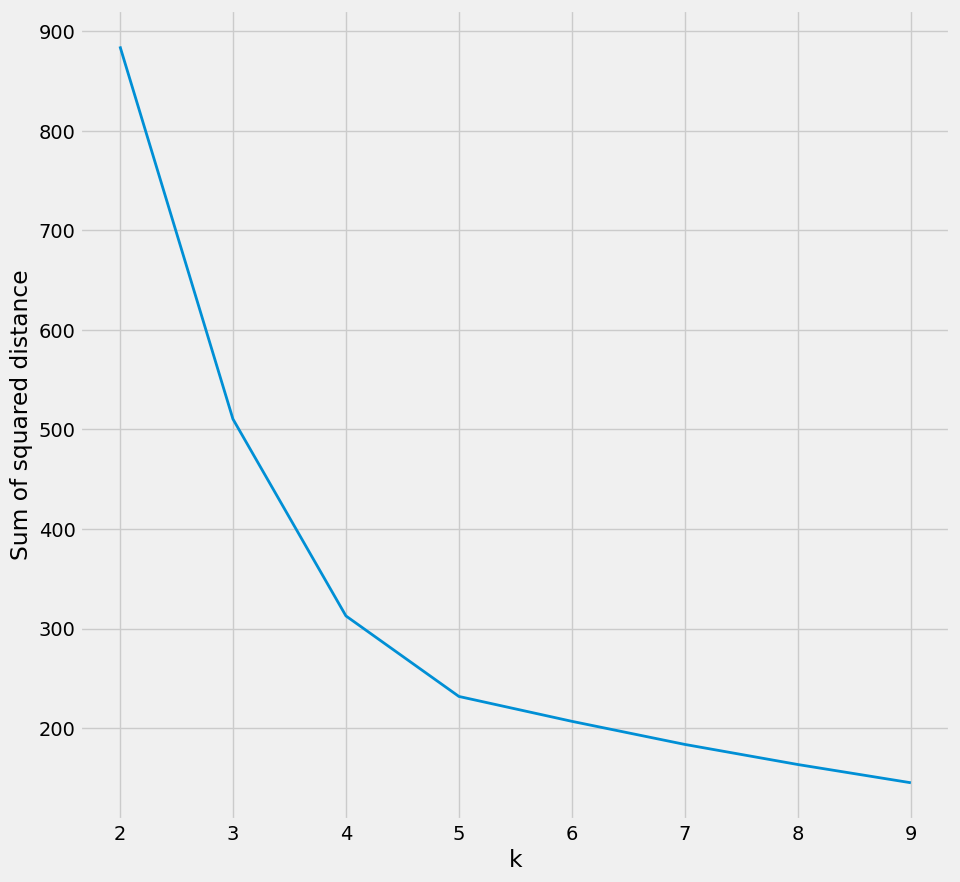

In [34]:
plt.figure(figsize=(10,10))
plt.plot(k_values,inertias)
plt.xlabel('k')
plt.ylabel('Sum of squared distance')
plt.show()

In [35]:
subset = df_cluster[cluster_columns]
kmeans = KMeans(n_clusters = 5, n_init=20, random_state=0)
df_cluster['cluster'] = kmeans.fit_predict(subset)

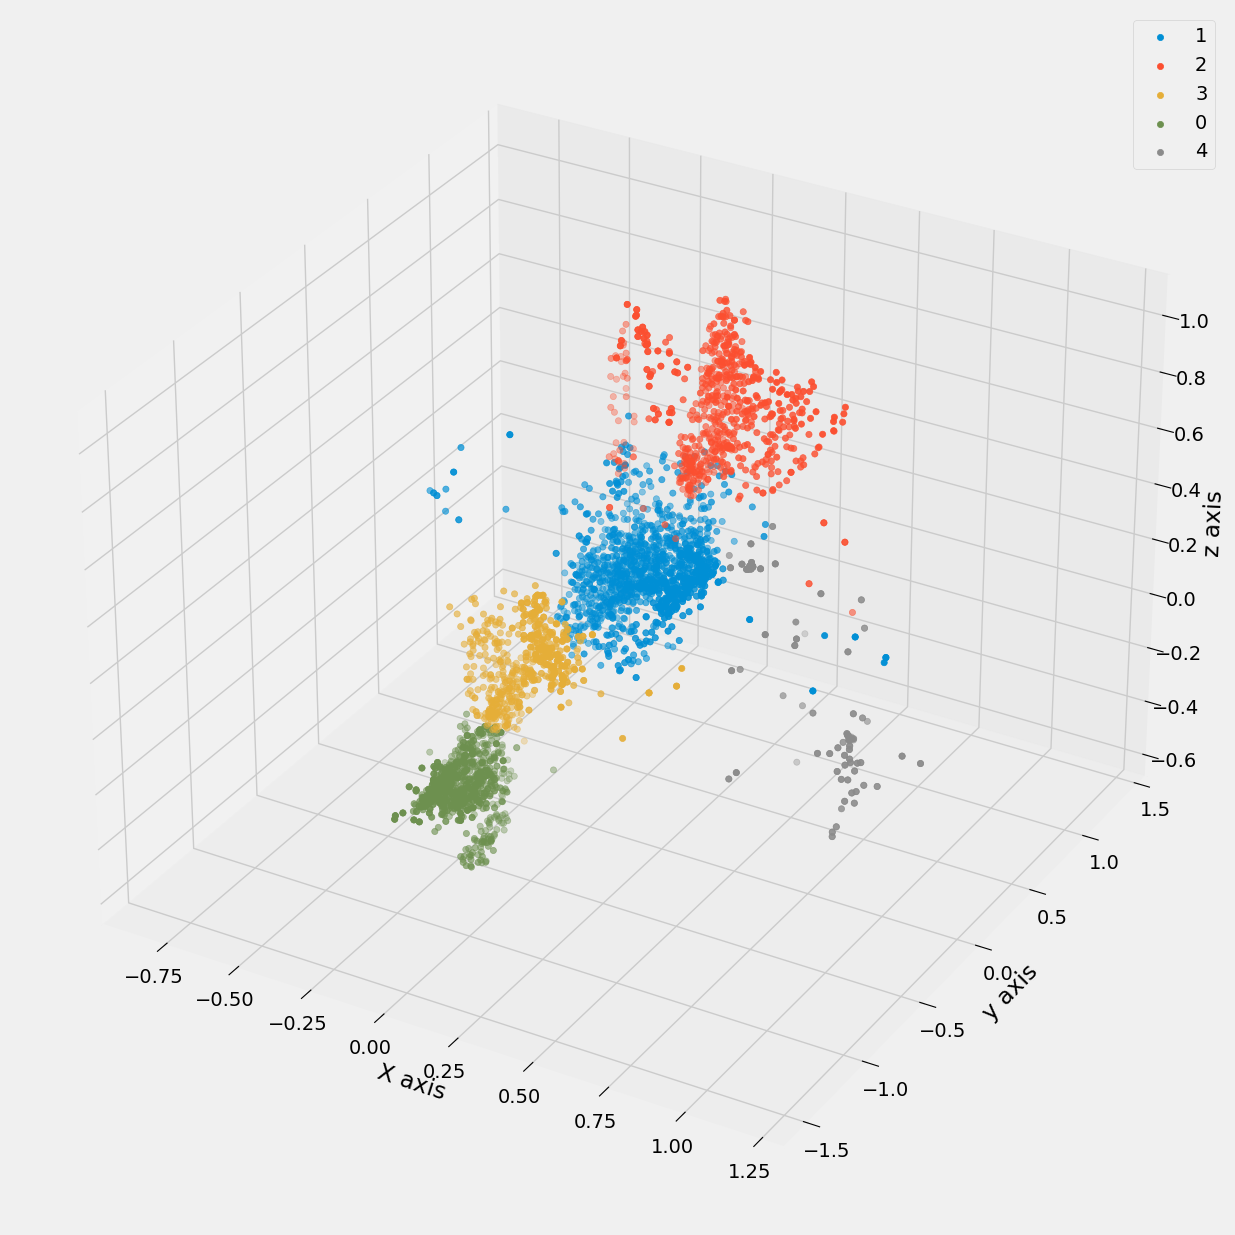

In [40]:
# Plot clusters

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection = '3d')

for c in df_cluster['cluster'].unique():
    subset = df_cluster[df_cluster['cluster'] == c]
    ax.scatter(subset['acc_x'], subset['acc_y'], subset['acc_z'], label = c)

ax.set_xlabel('X axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.legend()
plt.show()

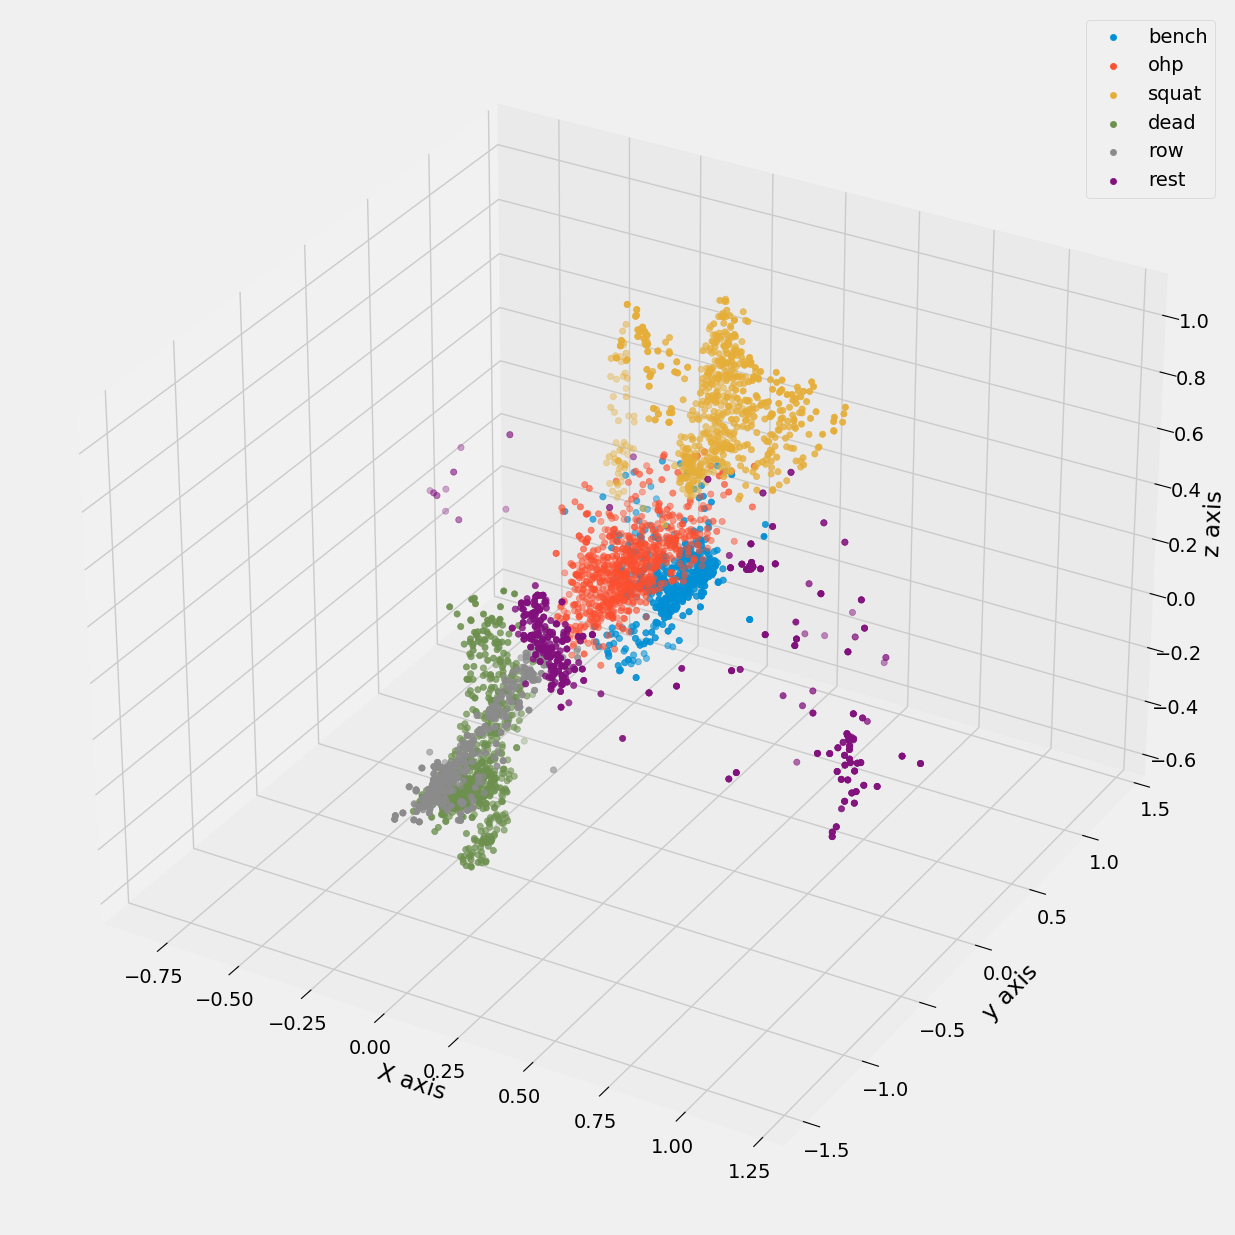

In [42]:
# Plot labels

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection = '3d')

for c in df_cluster['label'].unique():
    subset = df_cluster[df_cluster['label'] == c]
    ax.scatter(subset['acc_x'], subset['acc_y'], subset['acc_z'], label = c)

ax.set_xlabel('X axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.legend()
plt.show()

Export data

In [43]:
df_cluster.to_pickle('../../data/interim/03_data_features.pkl')